<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

<h1 style="text-align: center;">Fine-tuning a Large-Language Model</h1>

### Install Required packages
- [PyTorch](https://pytorch.org/get-started/locally/): Deep learning framework.
- Hugging Face Transformers(https://huggingface.co/docs/transformers/installation): To use pretrained state-of-the-art models.
- [Hugging Face Datasets](https://pypi.org/project/datasets/): Use public Hugging Face datasets
- [IPywidgets](https://ipywidgets.readthedocs.io/en/stable/user_install.html): For interactive notebook widgets

In [ ]:
!pip install torch torchview 'transformers[torch]' datasets ipywidgets nltk matplotlib uptrain

Import all required libraries

In [ ]:
import json
import nltk
import torch
import torchview
import transformers
import uptrain

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import (
    AutoModelForMaskedLM, AutoTokenizer,
    pipeline
)

from model_constants import *
from helper_funcs import *
from model_train import *


transformers.logging.set_verbosity_error()
nltk.download('vader_lexicon')

Define few cases to test our model performance before and after retraining.

In [35]:
testing_texts = [
    "Nike shoes are very [MASK]",
    "Nike atheletic wear is known for being very [MASK]",
    "Nike [MASK] shoes are very comfortable",
    "Trousers and Hoodies made by [MASK] are not very expensive",
    "Nike tshirts are famous for being [MASK]"
]

Initialize the model and tokenizer from the distilbert-base-uncased model

In [ ]:
model, tokenizer = get_model_and_tokenizer(model_checkpoint)

Let's visualize the model structure to understand the complexity behind these large language models

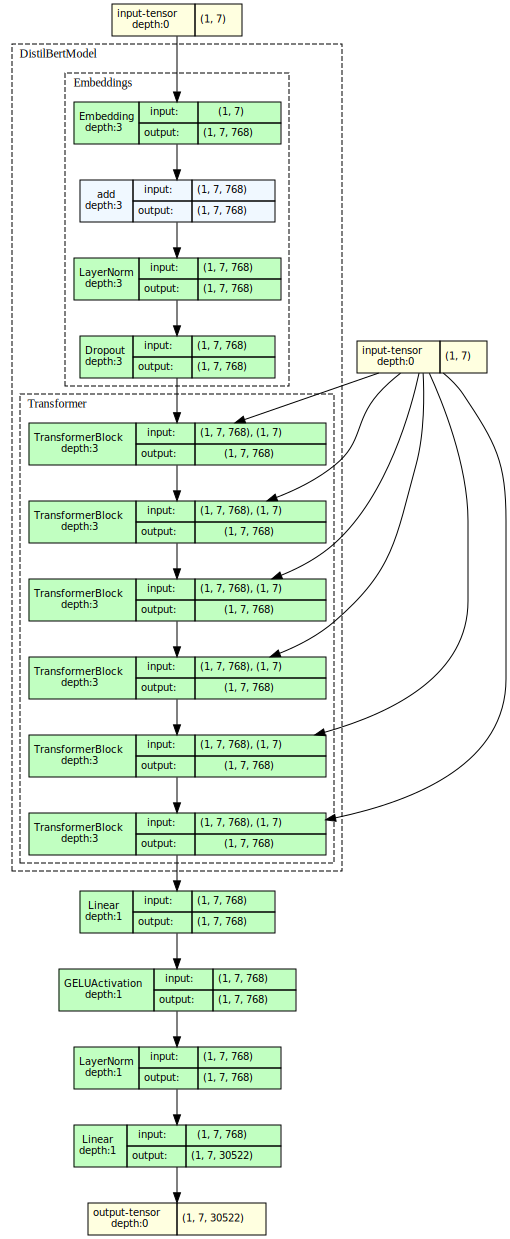

In [37]:
model_graph = torchview.draw_graph(model, input_data=tokenizer(testing_texts[0], return_tensors="pt").to(DEVICE), expand_nested=True)
model_graph.resize_graph(20)
model_graph.visual_graph

Take a look at the outputs of the vanilla distilbert-base-uncased model on predicting the outputs for the masked sentence:

"Nike shoes are very [MASK]"

Notice that we get the output "expensive" among the top 5 predictions. We want to fine-tune the model so that the predicted words form sentences that have a positive sentiment.

In [ ]:
original_model_outputs = [top_k_tokens(model, tokenizer, text, k=10) for text in testing_texts]
print('      Text:', testing_texts[0])
print('Top tokens:', original_model_outputs[0])

      Text: Nike shoes are very [MASK]
Top tokens: ['popular', 'durable', 'expensive', 'comfortable', 'fashionable', 'attractive', 'common', 'effective', 'versatile', 'valuable']


### Dataset Usage/Synthesis

For this task, we can use datasets that are available online, synthesize our own datasets or use a combination of the two. To demonstrate the functionality of UpTrain, synthesizing our own dataset will do.

In the dataset synthesis, we generate two forms of sentences that we want to fine-tune the model on. Refer to the function definition of `create_sample_dataset`. Note that some sentences that will be formed may not make complete sense but that is not very relevant.

In [ ]:
SYNTHESIZED_DATASET_SIZE = 25000
uptrain_save_fold_name = "uptrain_smart_data_bert"
synthesized_data_csv = 'data.csv'
synthesized_data_json = 'data.json'

# Create our own dataset of reviews for different companies, products, etc.
dataset = create_sample_dataset(SYNTHESIZED_DATASET_SIZE)
df = pd.DataFrame(dataset['data'])
df.reset_index(drop=True, inplace=True)

print(f'Dataset size: {len(df)}')
print(df)

df.to_csv(synthesized_data_csv)
create_dataset_from_csv(synthesized_data_csv, 'text', synthesized_data_json)

with open(synthesized_data_json) as file:
    dataset = json.loads(file.read())

# nike_products_dataset = {
#   'version': "1.0.0",
#   'source': "Product Data from Nike",
#   'url': "https://data.world/data-hut/product-data-from-nike",
#   'infile': "datasets/raw/nike_products.csv",
#   'outfile': "datasets/cleaned/nike_products.json"
# }

# nike_customer_reviews_kaggle_dataset = {
#   'version': "1.0.0",
#   'source': "Nike Onlinestore Customer Reviews",
#   'url': "https://www.kaggle.com/datasets/tinkuzp23/nike-onlinestore-customer-reviews",
#   'infile': "datasets/raw/nike_customer_reviews_kaggle.csv",
#   'outfile': "datasets/cleaned/nike_customer_reviews_kaggle.json"
# }

# products_kaggle_dataset = {
#   'version': "1.0.0",
#   'source': "Products: Prices, Descriptions, Reviews",
#   'url': "https://www.kaggle.com/datasets/thedevastator/nike-usa-products-prices-descriptions-and-custom",
#   'infile': "datasets/raw/products_kaggle.csv",
#   'outfile': "datasets/cleaned/products_kaggle.json"
# }

Define helper functions that UpTrain will use to detect edge cases which the model will fine-tune on instead of using the entire dataset.

- `nike_text_present_func`: Checks for the existence of "nike" in a sentence
- `nike_product_keyword_func`: Checks if the sentence contains a product that is manufactured by Nike
- `is_positive_sentiment_func`: Checks if a sentence has positive sentiment

In [40]:
vader_sia = SentimentIntensityAnalyzer()

def nike_text_present_func (inputs, outputs, gts=None, extra_args={}):
    is_present = []
    for text in inputs["text"]:
        text = text.lower()
        is_present.append(bool("nike" in text))
    return is_present

def nike_product_keyword_func (inputs, outputs, gts=None, extra_args={}):
    is_present = []
    for text in inputs["text"]:
        text = text.lower()
        is_present.append(any(word in text for word in PRODUCTS))
    return is_present

def is_positive_sentiment_func (inputs, outputs, gts=None, extra_args={}):
    is_positive = []
    for text in inputs["text"]:
        text = text.lower()
        if vader_sia.polarity_scores(text)["compound"] < 0:
            is_positive.append(False)
            continue
        is_positive.append(any(word in text for word in POSITIVE_SENTIMENT_ADJECTIVES))
    return is_positive

Define the UpTrain Framework configuration

In [ ]:
cfg = {
    'checks': [
        {
            "type": uptrain.Anomaly.EDGE_CASE,
            "signal_formulae": \
                uptrain.Signal("Is 'Nike' text present?", nike_text_present_func) &
                uptrain.Signal("Is it a Nike product?", nike_product_keyword_func) &
                uptrain.Signal("Is positive sentiment?", is_positive_sentiment_func)
        },

        {
            "type": uptrain.Anomaly.DATA_INTEGRITY,
            "measurable_args": {
                "type": uptrain.MeasurableType.INPUT_FEATURE,
                "feature_name": "text"
            },
            "integrity_type": "non_null"
        }
    ],

    # Define where to save the retraining dataset
    "retraining_folder": uptrain_save_fold_name,
    
    # Define when to retrain, define a large number because we
    # are not retraining yet
    "retrain_after": 10000000000
}

framework = uptrain.Framework(cfg)

Filter out the data that we want to specifically fine-tune on as defined by the configuration provided above

In [42]:
for index, sample in enumerate(dataset['data']):
    if index % 500 == 0:
        print(f'Processed {index} samples')
    inputs = {'data': {'text': [sample['text']]}}
    framework.log(inputs = inputs, outputs = None)

retraining_csv = uptrain_save_fold_name + '/1/smart_data.csv'
retraining_json = 'retrain_dataset.json'
create_dataset_from_csv(retraining_csv, 'text', retraining_json)

Processed 0 samples
50  edge cases identified out of  180  total samples
100  edge cases identified out of  361  total samples
Processed 500 samples
150  edge cases identified out of  566  total samples
200  edge cases identified out of  738  total samples
250  edge cases identified out of  941  total samples
Processed 1000 samples
300  edge cases identified out of  1136  total samples
350  edge cases identified out of  1347  total samples
Processed 1500 samples
400  edge cases identified out of  1539  total samples
450  edge cases identified out of  1725  total samples
500  edge cases identified out of  1874  total samples
Processed 2000 samples
550  edge cases identified out of  2042  total samples
600  edge cases identified out of  2200  total samples
650  edge cases identified out of  2412  total samples
Processed 2500 samples
700  edge cases identified out of  2561  total samples
750  edge cases identified out of  2709  total samples
800  edge cases identified out of  2879  total 

In [43]:
trainer, _, _, _ = retrain_model(model, retraining_json, num_train_epochs=8)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-46d1c5c8bc3ae63f/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 67
  Batch size = 64


The following columns in the training set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 594
  Num Epochs = 8
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 80
  Number of trainable parameters = 66985530


Before Training Eval Results:
 {
  "eval_loss": 3.820312738418579,
  "eval_runtime": 0.4257,
  "eval_samples_per_second": 157.373,
  "eval_steps_per_second": 4.698
}
  Before Training Perplexity: 45.62


Step,Training Loss,Validation Loss
10,2.072900,0.947630
20,0.794700,0.692525
30,0.698300,0.620223
40,0.613100,0.591150
50,0.596200,0.638525
60,0.581100,0.562007
70,0.577100,0.603652
80,0.553900,0.607553


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 67
  Batch size = 64
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForMaskedLM.forward` and have been ignored: word_ids. If word_ids are not expected by `DistilBertForMaskedLM.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 67
  Batch size = 64
Saving model checkpoint to distilbert-base-uncased-finetuned-llm-uptrain/checkpoint-25
Configuration saved in distilbert-base-uncased-finetuned-llm-uptrain/checkpoint-25/config.json
Model weights saved in distilbert-base-uncased-finetuned-llm-uptrain/checkpoint-25/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-llm-uptrain/ch

After Training Eval Results:
 {
  "eval_loss": 0.5846443176269531,
  "eval_runtime": 0.4075,
  "eval_samples_per_second": 164.436,
  "eval_steps_per_second": 4.909,
  "epoch": 8.0
}
  After Training Perplexity: 1.79


(<transformers.trainer.Trainer at 0x7f3edc1c6850>,
 {'eval_loss': 3.820312738418579,
  'eval_runtime': 0.4257,
  'eval_samples_per_second': 157.373,
  'eval_steps_per_second': 4.698},
 {'eval_loss': 0.5846443176269531,
  'eval_runtime': 0.4075,
  'eval_samples_per_second': 164.436,
  'eval_steps_per_second': 4.909,
  'epoch': 8.0},
 TrainOutput(global_step=80, training_loss=0.810921025276184, metrics={'train_runtime': 81.0607, 'train_samples_per_second': 58.623, 'train_steps_per_second': 0.987, 'total_flos': 157482653442048.0, 'train_loss': 0.810921025276184, 'epoch': 8.0}))

In [44]:
retrained_model_outputs = [top_k_tokens(model, tokenizer, text, k=10) for text in testing_texts]
print('                Text:', testing_texts[0])
print(' Original Top tokens:', original_model_outputs[0])
print('Retrained Top tokens:', retrained_model_outputs[0])

                Text: Nike shoes are very [MASK]
 Original Top tokens: ['popular', 'durable', 'expensive', 'comfortable', 'fashionable', 'attractive', 'common', 'effective', 'versatile', 'valuable']
Retrained Top tokens: ['durable', 'comfortable', 'versatile', 'fashionable', 'efficient', 'fit', 'lightweight', 'flexible', 'cheap', 'impressive']


In [45]:
for i in range(len(testing_texts)):
    print('                Text:', testing_texts[i])
    print(' Original Top tokens:', original_model_outputs[i][:5])
    print('Retrained Top tokens:', retrained_model_outputs[i][:5])
    print()

                Text: Nike shoes are very [MASK]
 Original Top tokens: ['popular', 'durable', 'expensive', 'comfortable', 'fashionable']
Retrained Top tokens: ['durable', 'comfortable', 'versatile', 'fashionable', 'efficient']

                Text: Nike atheletic wear is known for being very [MASK]
 Original Top tokens: ['durable', 'expensive', 'popular', 'fashionable', 'rare']
Retrained Top tokens: ['durable', 'efficient', 'lightweight', 'fit', 'fashionable']

                Text: Nike [MASK] shoes are very comfortable
 Original Top tokens: ['polo', 'golf', 'swim', 'tennis', 'nike']
Retrained Top tokens: ['soccer', 'running', 'training', 'basketball', 'football']

                Text: Trousers and Hoodies made by [MASK] are not very expensive
 Original Top tokens: ['women', 'manufacturers', 'men', 'amateurs', 'slaves']
Retrained Top tokens: ['nike', 'honda', 'bmw', 'samsung', 'lego']

                Text: Nike tshirts are famous for being [MASK]
 Original Top tokens: ['.', ':', ';